<a href="https://colab.research.google.com/github/ugursirvermez/PyTorch_Education/blob/main/06_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyTorch Özel Veri Kümeleri (FoodVisionMini)

In [329]:
#KUTUPHANELER
import torch
from torch import nn
print(torch.__version__)
#Pytorch 1.10.0 üstü gereklidir!
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch import nn
from timeit import default_timer as timer # Zaman ayarları için var.
from tqdm.auto import tqdm #Eğitimi işlem barında göstermek için kullanacağız. Progess bar kütüphanesi
import requests #İnternet işlemleri için kütüphane
import random #rastgele Python kütüphanesi
from PIL import Image #Python Imaging Library -> kütüphanenin ne işe yaradığını isminden anlamışsınızdır :)
import os # Operation System kütüphanesi
import zipfile #Zip Dosyaları ile ilgili işlemleri yapar.
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, Dict, List

#Cihazımızı tanıtalım.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

#The Food-101 Dataset Atıfı
#@inproceedings{bossard14,
#  title = {Food-101 -- Mining Discriminative Components with Random Forests},
#  author = {Bossard, Lukas and Guillaumin, Matthieu and Van Gool, Luc},
#  booktitle = {European Conference on Computer Vision},
#  year = {2014}
#}

2.4.1+cu121
cpu


## DataSet İndirme

In [330]:
#Özel veri setimizi indirip oluşturalım.
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

#Eğer dosya yoksa indir.
if image_path.is_dir():
	print(f"{image_path} dosyası zaten var...")
else:
	print(f"{image_path} dosyası oluşturuluyor...")
	image_path.mkdir(parents=True, exist_ok=True)

#Dosyaları indir
with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
	request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
	print("Zip dosyası indiriliyor...")
	f.write(request.content)

#İnen dosyaları zip'ten çıkaralım.
with zipfile.ZipFile(data_path/ "pizza_steak_sushi.zip", "r") as zip_ref:
	print("Zip'ten dosyalar çıkarılıyor...")
	zip_ref.extractall(image_path)

print("VERİ SETİ OLUŞTURULDU!")

data/pizza_steak_sushi dosyası zaten var...
Zip dosyası indiriliyor...
Zip'ten dosyalar çıkarılıyor...
VERİ SETİ OLUŞTURULDU!


##Özel Veri Setini Tensörlere Dönüştürme

In [331]:
#Verileri Hazırlama Aşaması
def walk_through_dir(dir_path):
	#Tensöre dönüştürmeden önce dosyaya ulaşmamız gerekiyor.
	#Bunun için klasör yolu, klasör adı, dosya adını bulmalıyız.
	for dirpath, dirnames, filenames in os.walk(dir_path):
		print(f"{len(dirnames)} adet dosya ve {len(filenames)} resimler; belirtilen {dirpath} yolunda")

walk_through_dir(image_path) #yukarıda image_path'i tanıtmıştık.

2 adet dosya ve 0 resimler; belirtilen data/pizza_steak_sushi yolunda
3 adet dosya ve 0 resimler; belirtilen data/pizza_steak_sushi/test yolunda
0 adet dosya ve 25 resimler; belirtilen data/pizza_steak_sushi/test/pizza yolunda
0 adet dosya ve 31 resimler; belirtilen data/pizza_steak_sushi/test/sushi yolunda
0 adet dosya ve 19 resimler; belirtilen data/pizza_steak_sushi/test/steak yolunda
3 adet dosya ve 0 resimler; belirtilen data/pizza_steak_sushi/train yolunda
0 adet dosya ve 78 resimler; belirtilen data/pizza_steak_sushi/train/pizza yolunda
0 adet dosya ve 72 resimler; belirtilen data/pizza_steak_sushi/train/sushi yolunda
0 adet dosya ve 75 resimler; belirtilen data/pizza_steak_sushi/train/steak yolunda


data/pizza_steak_sushi/test/steak/966174.jpg yolundaki ve steak türündeki dosya şu şekildedir: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FDE492E9E70>


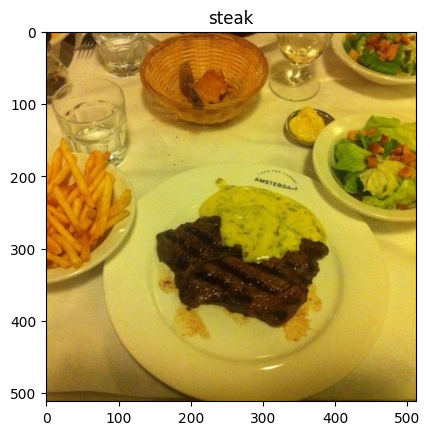

In [332]:
#Train ve Test klasörlerini Ayarlama
#klasörlerin yolunu belirtelim.
train_dir = image_path / "train"
test_dir = image_path / "test"

#Verilerimizi görsel olarak görelim. Nelere sahibiz?
random.seed(42)
image_path_list = list(image_path.glob("*/*/*.jpg")) #bütün birbirleriyle ilişkili dosyaları yaz.
#print(image_path_list) #Bütün dosya yollarını yazdırıyoruz.

#Rastgele resim yolu seçelim.
random_image_path = random.choice(image_path_list)

#Rastgele resmi rastgele dosya yoluyla görelim.
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)
print(f"{random_image_path} yolundaki ve {image_class} türündeki dosya şu şekildedir: {img}")
plt.imshow(img)
plt.title(image_class)
plt.show()

##Tensöre Dönüştürme Aşaması-1

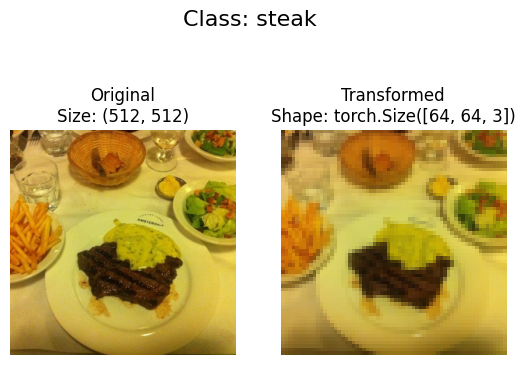

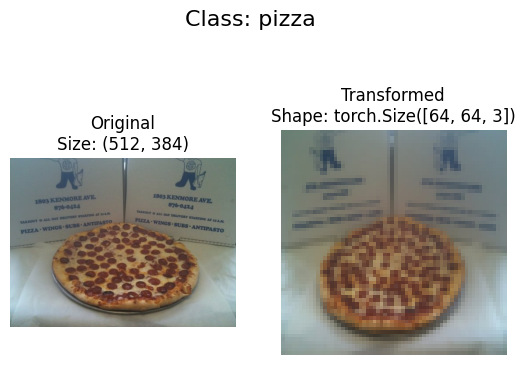

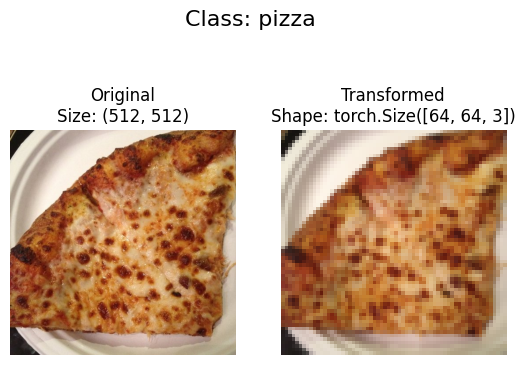

In [333]:
#Verileri Görelim.
#Reimleri array'e çevirelim.
img_as_array = np.asarray(img) #Veriler sayısallaşır ancak aradığımız tensör değildir!

#Dataset ve DataLoader ile verileri dönüştürüp kullanacağız.
#Veriyi torchvision.transforms sayesinde dönüştüreceğiz.
data_transform = transforms.Compose([
#Resimlerimizi 64x64'e dönüştüreceğiz.
transforms.Resize(size=(64,64)),
#resimleri yatay çevirelim.
transforms.RandomHorizontalFlip(p=0.5),
#Verimizi tensöre çevirelim. PIL Image veya numpy kabul eder.
transforms.ToTensor()])

#Dönüşen verilerimizi görelim.
def plot_transformed_images(image_paths, transform, n=3, seed=42):
	#Rastgele verilere bakalım.
	if seed:
		random.seed(seed)
	random_image_paths = random.sample(image_paths, k=n)
	#Resimlerin yollarını bulalım.
	for image_path in random_image_paths:
		with Image.open(image_path) as f:
			fig,ax = plt.subplots(nrows=1,ncols=2)
			ax[0].imshow(f)
			ax[0].set_title(f"Original\nSize: {f.size}")
			ax[0].axis(False)
			#Dönüşen ve görülen verilere bak. Tensörün boyutuna bakılmalı.
			transformed_image = transform(f).permute(1,2,0) #(Color,Height,Width) -> (Height,Width,Color)
			ax[1].imshow(transformed_image)
			ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
			ax[1].axis("off")
			fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

#Fonksiyonu Çalıştıralım.
plot_transformed_images(image_paths=image_path_list, transform=data_transform, n=3, seed=42)

##Veri Doldurma Seçenek-1 (2.Seçenek Notion'da)

In [334]:
#torchvision.datasets.ImageFolder kullanarak verileri doldurabiliriz.
from torchvision import datasets
#root -> Hangi dosyaya?, transform -> kim dönüşecek?, target_transform -> kime dönüşecek?
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
#Aynı yöntem uygulanır.
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

#Sınıf isimlerini listeleyelim.
class_names = train_data.classes
#Sözlük(Dict) olarak yazalım.
class_dict = train_data.class_to_idx
#Shape, Type, Label uyuşmazlığı için veriyi durmadan kontrol etmeliyiz.

##Dataset -> DataLoader

In [335]:
#DataLoader datasetleri kullanmamızı sağlayan bir araçtır.
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE,
															num_workers=os.cpu_count(),shuffle=True)

test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE,
															num_workers=os.cpu_count(),shuffle=False)

#DataLoader yazdıralım.
img, label = next(iter(test_dataloader))
print(f"Image Shape: {img.shape} (BS,C,H,W)")
print(f"Label Shape: {label.shape}")

Image Shape: torch.Size([32, 3, 64, 64]) (BS,C,H,W)
Label Shape: torch.Size([32])


##Veri Doldurma-2

In [336]:
#Veri Doldurma-2
#os.scandir() -> hedef dosyayı dönüştürmek için dosyayı tarayacak
target_directory = train_dir
#hedef yoldaki sınıf isimlerini alalım.
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
print(class_names_found)
#Sınıf bulma fonksiyonu yazalım.
def find_classes(directory: str) -> Tuple[list[str], Dict[str, int]]:
	#scandir ile tarama yapalım.
	classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
	if not classes:
		raise FileNotFoundError(f"Herhangi bir sınıf bulunamadı...{directory}")
	class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
	return classes, class_to_idx

find_classes(target_directory)

['pizza', 'steak', 'sushi']


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#Sıfırdan Özel Veri Seti Yazma

In [337]:
#Sıfırdan Özel Veri Seti Yazma
from torch.utils.data import Dataset #en çok bunu kullanacağımız için bir daha belirttik.
from pathlib import Path

#torch.utils.data import Dataset üzerinden alt bır sınıf yaratalım.
class ImageFolderCustom(Dataset):
	#verisetimizi başlatalım. Targ_dir -> hedeflenen konum
	def __init__(self, targ_dir:str, transform=None):
		#Sınıfın çıktıları bütün resimlerin yollarını vermek olacak.
		self.paths = list(Path(targ_dir).glob("*/*.jpg"))
		#Transform'u kuralım.
		self.transform = transform
		#Sınıfları yaratma ve sınıfları id ekleme
		self.classes, self.class_to_idx = find_classes(targ_dir)

	#Görselleri dolduran fonksiyon yazıyoruz.
	def load_image(self, index: int) -> Image.Image:
		#Görseli açıp bize yolunu verecek.
		image_path = self.paths[index]
		print(image_path)
		return Image.open(image_path)

	#__len__() adında kendisinin üzerine (overwrite) yazacak metot
	def __len__(self) -> int:
		#Örneklemin toplam değerini döndürecek.
		print(len(self.paths))
		return len(self.paths)

	#Belirtilen nesneyi getirme fonksiyonu -> Örneklem grubundan veri seçme
	def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
		#Veri ve etiketi (X, y) olarak verecek.
		img = self.load_image(index)
		class_name = self.paths[index].parent.name #dataFolder/class_name/xx.jpg
		class_idx = self.class_to_idx[class_name]

		#Dönüştür her şeyi
		if self.transform:
			print("Veri dönüştürülüyor...")
			return self.transform(img), class_idx #Data, Label (X,y)
		else:
			print("Dönüştürme bitti...")
			return img,class_idx

##ImageFolderCustom Sınıfını Test Etme

In [338]:
#Transform tasarlayalım.
from torchvision import transforms

#Train Transform
train_transforms = transforms.Compose([
#Resimlerimizi 64x64'e dönüştüreceğiz.
transforms.Resize(size=(64,64)),
#resimleri yatay çevirelim.
transforms.RandomHorizontalFlip(p=0.5),
#Verimizi tensöre çevirelim. PIL Image veya numpy kabul eder.
transforms.ToTensor()])

#Test Transform
test_transforms = transforms.Compose([
#Resimlerimizi 64x64'e dönüştüreceğiz.
transforms.Resize(size=(64,64)),
#Verimizi tensöre çevirelim. PIL Image veya numpy kabul eder.
transforms.ToTensor()])

#ImageFolderCustom sınıfını test edelim.
train_data_custom = ImageFolderCustom(targ_dir = train_dir, transform = train_transforms)
test_data_custom = ImageFolderCustom(targ_dir = test_dir, transform = test_transforms)

print(len(train_data), len(train_data_custom))
print(len(test_data), len(test_data_custom))

225
225 225
75
75 75


##Dönüştürülenleri Görselleştirme

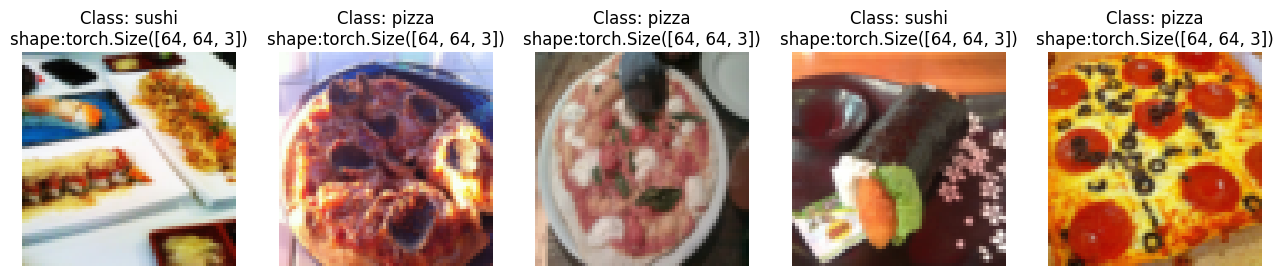

In [339]:
#Dönüştürülenleri Görselleştirme
#Öncelikle rastgele verileri hedeflenen verisetinden seçip 10 tanesini görselleştireceğiz.
#Matplotlib kullanacağız.
#Bunlar için bir fonksiyon yazalım.
def display_random_images(dataset: torch.utils.data.Dataset,
													classes:List[str] = None,
													n: int = 10,
													display_shape: bool = True,
													seed:int = None):
	#n çok büyükse,
	if n > 10:
		n = 10
		display_shape = False
		print("n değerli 10'dan büyük olamaz!")

	#Seed edelim.
	if seed:
		random.seed(seed)

	#Rastgele verilerin index değerini al.
	random_samples_idx = random.sample(range(len(dataset)), k=n)

	#görsel ayarı
	plt.figure(figsize=(16,8))

	#Random index'leri döngüye alalım ve görselleştirelim.
	for i,targ_sample in enumerate(random_samples_idx):
		targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

		#Tensör alt boyutlarını da görsele dahil et.
		targ_image_adjust = targ_image.permute(1,2,0) #(H,W,C) boyutuna dönüştürelim.

		#Görseli oluşturalım.
		plt.subplot(1, n, i+1)
		plt.imshow(targ_image_adjust)
		plt.axis("off")
		if classes:
			title = f"Class: {classes[targ_label]}"
			if display_shape:
				title = title + f"\nshape:{targ_image_adjust.shape}"
		plt.title(title)

#Fonksiyonu test edelim.
display_random_images(train_data, n=5, classes=class_names, seed=42)

n değerli 10'dan büyük olamaz!
225
data/pizza_steak_sushi/train/pizza/3338774.jpg
Veri dönüştürülüyor...
data/pizza_steak_sushi/train/pizza/3338774.jpg
Veri dönüştürülüyor...
data/pizza_steak_sushi/train/pizza/1285298.jpg
Veri dönüştürülüyor...
data/pizza_steak_sushi/train/pizza/1285298.jpg
Veri dönüştürülüyor...
data/pizza_steak_sushi/train/pizza/1572608.jpg
Veri dönüştürülüyor...
data/pizza_steak_sushi/train/pizza/1572608.jpg
Veri dönüştürülüyor...
data/pizza_steak_sushi/train/steak/3577618.jpg
Veri dönüştürülüyor...
data/pizza_steak_sushi/train/steak/3577618.jpg
Veri dönüştürülüyor...
data/pizza_steak_sushi/train/pizza/2800325.jpg
Veri dönüştürülüyor...
data/pizza_steak_sushi/train/pizza/2800325.jpg
Veri dönüştürülüyor...
data/pizza_steak_sushi/train/steak/1961025.jpg
Veri dönüştürülüyor...
data/pizza_steak_sushi/train/steak/1961025.jpg
Veri dönüştürülüyor...
data/pizza_steak_sushi/train/steak/167069.jpg
Veri dönüştürülüyor...
data/pizza_steak_sushi/train/steak/167069.jpg
Veri dönüş

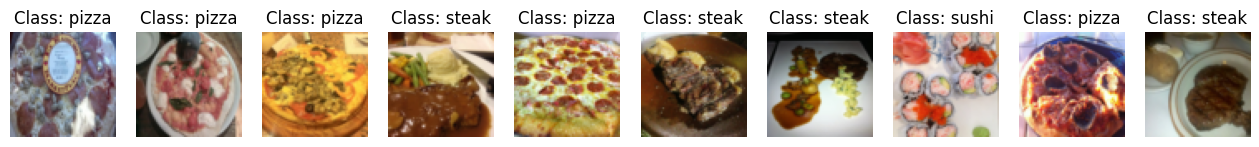

In [340]:
#ImageFolderCustom alt sınıfına ait veri setinden veri çekelim.
display_random_images(train_data_custom, n=20, classes=class_names, seed=None)

#Data Augmentation

[PosixPath('data/pizza_steak_sushi/test/pizza/416067.jpg'), PosixPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'), PosixPath('data/pizza_steak_sushi/test/pizza/2508636.jpg'), PosixPath('data/pizza_steak_sushi/test/pizza/2218680.jpg'), PosixPath('data/pizza_steak_sushi/test/pizza/930553.jpg'), PosixPath('data/pizza_steak_sushi/test/pizza/714866.jpg'), PosixPath('data/pizza_steak_sushi/test/pizza/648055.jpg'), PosixPath('data/pizza_steak_sushi/test/pizza/2871261.jpg'), PosixPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'), PosixPath('data/pizza_steak_sushi/test/pizza/309892.jpg'), PosixPath('data/pizza_steak_sushi/test/pizza/344397.jpg'), PosixPath('data/pizza_steak_sushi/test/pizza/3475871.jpg'), PosixPath('data/pizza_steak_sushi/test/pizza/195160.jpg'), PosixPath('data/pizza_steak_sushi/test/pizza/971934.jpg'), PosixPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'), PosixPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'), PosixPath('data/pizza_steak_sushi/test/pizza/54

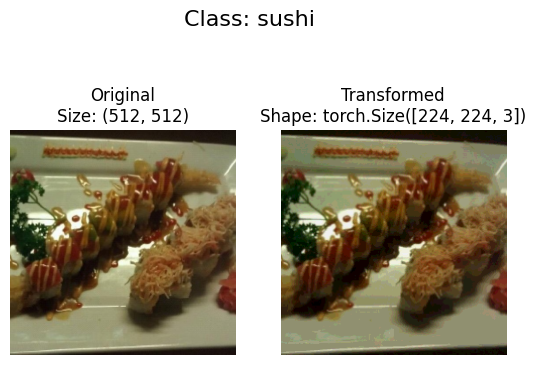

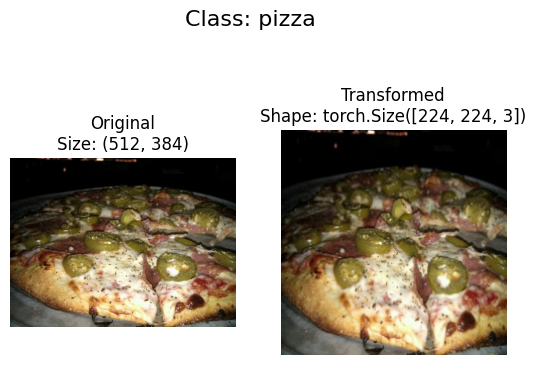

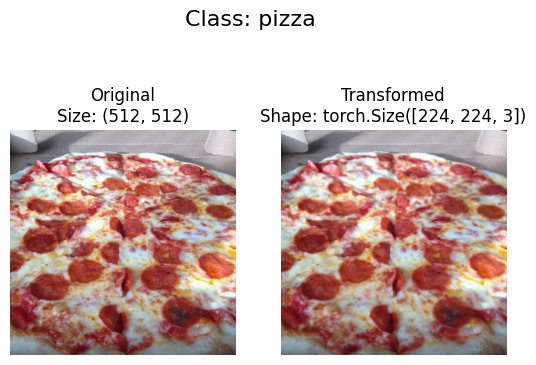

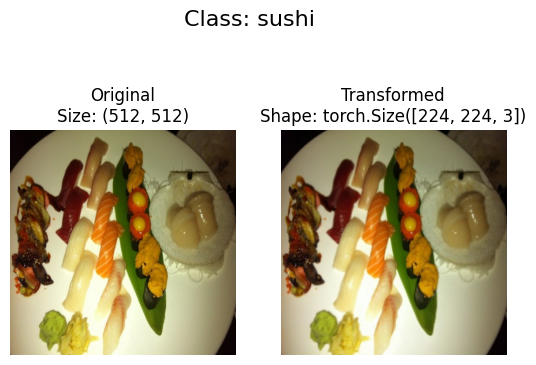

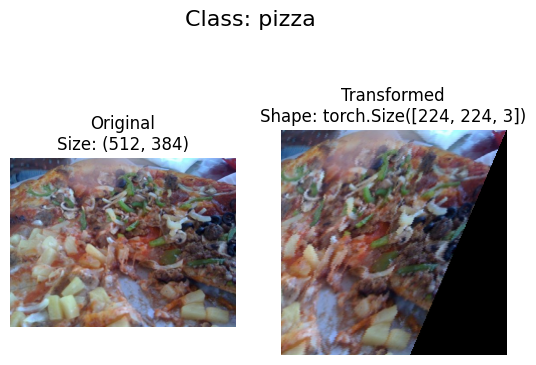

In [341]:
#Data Augmentation
#TrivialAugment yapalım.

#Train Transform
train_transforms = transforms.Compose([
#Resimlerimizi 224x224'e dönüştüreceğiz.
transforms.Resize(size=(224,224)),
#resimlere TrivialAugment uygulayalım.
transforms.TrivialAugmentWide(num_magnitude_bins=31), #Orjinalinden ne kadar farklı aralık?
#Verimizi tensöre çevirelim. PIL Image veya numpy kabul eder.
transforms.ToTensor()])

#Test Transform
test_transforms = transforms.Compose([
#Resimlerimizi 224x224'e dönüştüreceğiz.
transforms.Resize(size=(224,224)),
#Verimizi tensöre çevirelim. PIL Image veya numpy kabul eder.
transforms.ToTensor()])

image_path_list = list(image_path.glob("*/*/*.jpg"))
print(image_path_list)
plot_transformed_images(image_paths=image_path_list, transform=train_transforms, n= 5, seed=None)

#FoodVision Taban Modeli Geliştirme (Model_0)

In [342]:
#TinyVGG mimarisi ile fakat Data Augmentation uygulamadan model_0 inşa edeceğiz.
simple_transforms = transforms.Compose([
#Resimlerimizi 64x64'e dönüştüreceğiz.
transforms.Resize(size=(64,64)),
#Verimizi tensöre çevirelim. PIL Image veya numpy kabul eder.
transforms.ToTensor()])

NUM_WORKERS = os.cpu_count()

#Doldurma ve veri setini dönüştürme
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transforms)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transforms)

#DATALOADER oluşturma
train_dataloader_simple = DataLoader(dataset=train_data_simple, batch_size=BATCH_SIZE, shuffle=True,num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple, batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS)

#TinyVGG model sınıfı oluşturma
class TinyVGG(nn.Module):
	def __init__(self, input_shape:int, hidden_units:int, output_shape: int) -> None:
		super().__init__()
		self.conv_block_1 = nn.Sequential(nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
																			nn.ReLU(),
																			nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
																			nn.ReLU(),
																			nn.MaxPool2d(kernel_size=2, stride=2))
		self.conv_block_2 = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
																			nn.ReLU(),
																			nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
																			nn.ReLU(),
																			nn.MaxPool2d(kernel_size=2, stride=2))
		self.classifier = nn.Sequential(nn.Flatten(), nn.Linear(in_features=hidden_units *16 *16, out_features=output_shape))

	def forward(self, x):
		x = self.conv_block_1(x)
		x = self.conv_block_2(x)
		x = self.classifier(x)
		return x
		#return self.classifier(self.conv_block_2(self.conv_block_1(x)))

##İşlemleri Model_0'da Uygulama

In [343]:
#model_0 yaratma
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)

#Şimdilik tek resmi işleme sokalım.
image_batch, label_batch = next(iter(train_dataloader_simple))
model_0(image_batch.to(device))

tensor([[0.0578, 0.0634, 0.0351],
        [0.0657, 0.0650, 0.0398],
        [0.0702, 0.0678, 0.0412],
        [0.0687, 0.0646, 0.0417],
        [0.0625, 0.0613, 0.0355],
        [0.0587, 0.0595, 0.0358],
        [0.0634, 0.0637, 0.0376],
        [0.0653, 0.0615, 0.0376],
        [0.0678, 0.0621, 0.0349],
        [0.0620, 0.0599, 0.0371],
        [0.0607, 0.0628, 0.0387],
        [0.0638, 0.0589, 0.0352],
        [0.0658, 0.0611, 0.0369],
        [0.0703, 0.0689, 0.0330],
        [0.0557, 0.0571, 0.0356],
        [0.0632, 0.0642, 0.0388],
        [0.0639, 0.0616, 0.0375],
        [0.0605, 0.0600, 0.0374],
        [0.0623, 0.0627, 0.0368],
        [0.0740, 0.0676, 0.0400],
        [0.0621, 0.0613, 0.0361],
        [0.0632, 0.0599, 0.0366],
        [0.0662, 0.0627, 0.0334],
        [0.0637, 0.0622, 0.0394],
        [0.0670, 0.0666, 0.0363],
        [0.0650, 0.0601, 0.0405],
        [0.0639, 0.0597, 0.0395],
        [0.0733, 0.0687, 0.0412],
        [0.0697, 0.0631, 0.0402],
        [0.062

##TorchInfo Kullanımı

In [344]:
#TorchInfo Kurulumu
try:
	import torchinfo
except:
	!pip install torchinfo
#Kütüphane dahil edildikten sonra devam eder.

from torchinfo import summary

#summary -> modelin genel özetidir.
#inputSize -> Batch, Color, Height, Width
summary(model_0, input_size=[32,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

##Test ve Train Fonksiyonları

In [345]:
#Train ve Test Döngü Fonksiyonları
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
							 loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer):

	#Eğitim modunu açtık.
	model.train()

	#tutarlılık ve kayıp değerleri
	train_loss, train_acc = 0, 0

	#döngüyü oluşturma
	for batch,(X,y) in enumerate(dataloader):
		X,y = X.to(device), y.to(device)

		#Forward etme
		y_pred = model(X)

		#kaybı hesaplama
		loss = loss_fn(y_pred, y)
		train_loss += loss.item()

		#Opitimizer
		optimizer.zero_grad()

		#kayıp geri döndürme (backward)
		loss.backward()

		#Tutarlılığı hesaplama
		y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
		train_acc += (y_pred_class==y).sum().item()/len(y_pred_class)

	train_loss = train_loss / len(dataloader)
	train_acc = train_acc / len(dataloader)
	return train_loss, train_acc

#Test Adımlarını yapalım.
def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
							 loss_fn: torch.nn.Module, device=device):

	#eval modu aç.
	model.eval()

	#test tutarlılık ve kayıp değerlerini aç.
	test_loss, test_acc = 0, 0

	with torch.inference_mode():
		for batch, (X, y) in enumerate(dataloader):
			X, y = X.to(device), y.to(device)

			#Forward edelim.
			test_pred_logits = model(X)

			#kaybı hesaplama
			loss = loss_fn(test_pred_logits, y)
			test_loss += loss.item()

			#Tutarlılık hesabı
			test_pred_labels = test_pred_logits.argmax(dim=1)
			test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

	#metrikleri yazdıralım.
	test_loss = test_loss / len(dataloader)
	test_acc = test_acc / len(dataloader)
	return test_loss, test_acc

##Eğitim Dongusunu Yazma

In [346]:
#train() uygulama ve değerlendirme
def train(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader,
					test_dataloader: torch.utils.data.DataLoader, optimizer, loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
					epochs: int = 5, device=device):

	#boş sonuçları tasarlayalım.
	results = {"train_loss":[], "train_acc":[], "test_loss":[], "test_acc":[]}

	#donguyu olusturalım.
	for epoch in tqdm(range(epochs)):
		#Step fonksiyonlarımızı test ve train olarak yazıyoruz.
		train_loss, train_acc = train_step(model=model,
																			 dataloader=train_dataloader,
																			 loss_fn=loss_fn, optimizer=optimizer)
		test_loss, test_acc = test_step(model=model,
																			 dataloader=test_dataloader,
																			 loss_fn=loss_fn,
																			 device=device)

		print(f"Epoch: {epoch} | Train_loss: {train_loss} | Train_acc: {train_acc} | Test_loss: {test_loss} | Test_acc: {test_acc}")

		#Sonuçlara ekleyelim.
		results["train_loss"].append(train_loss)
		results["train_acc"].append(train_acc)
		results["test_loss"].append(test_loss)
		results["test_acc"].append(test_acc)

	#Sonucu gönder.
	return results

#Modeli Eğitip Değerlendirme aşaması
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#döngü sayısını ayarlama
NUM_EPOCHS = 10

#Tekrar TinyVGG sınıfını türetelim.
model_0 = TinyVGG(input_shape = 3, hidden_units = 10, output_shape=len(train_data.classes)).to(device)

#loss ve optimizer
loss_fn = nn.CrossEntropyLoss()
#Adam algoritmasını uygulayacağız.
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)

#Zamanlayıcıyı başlatalım.
start_time = timer()

#model_0'ı eğitelim.
model_0_results = train(model = model_0, train_dataloader = train_dataloader_simple,
												test_dataloader = test_dataloader_simple, optimizer = optimizer,
												loss_fn = loss_fn, epochs = NUM_EPOCHS)
#Zamanı durduralım.
end_time = timer()
print(f"Total Training Time: {end_time - start_time: .3f} seconds...")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train_loss: 1.0973651856184006 | Train_acc: 0.26171875 | Test_loss: 1.1037269830703735 | Test_acc: 0.20833333333333334
Epoch: 1 | Train_loss: 1.0974323451519012 | Train_acc: 0.3828125 | Test_loss: 1.1037269830703735 | Test_acc: 0.20833333333333334
Epoch: 2 | Train_loss: 1.0976254343986511 | Train_acc: 0.3828125 | Test_loss: 1.1037269830703735 | Test_acc: 0.20833333333333334
Epoch: 3 | Train_loss: 1.097390815615654 | Train_acc: 0.3828125 | Test_loss: 1.1037269830703735 | Test_acc: 0.20833333333333334
Epoch: 4 | Train_loss: 1.0971609801054 | Train_acc: 0.3828125 | Test_loss: 1.1037269830703735 | Test_acc: 0.20833333333333334
Epoch: 5 | Train_loss: 1.097766637802124 | Train_acc: 0.26171875 | Test_loss: 1.1037269830703735 | Test_acc: 0.20833333333333334
Epoch: 6 | Train_loss: 1.1005257815122604 | Train_acc: 0.26171875 | Test_loss: 1.1037269830703735 | Test_acc: 0.20833333333333334
Epoch: 7 | Train_loss: 1.1002151370048523 | Train_acc: 0.26171875 | Test_loss: 1.1037269830703735 |

##Loss Curve Yazdırma

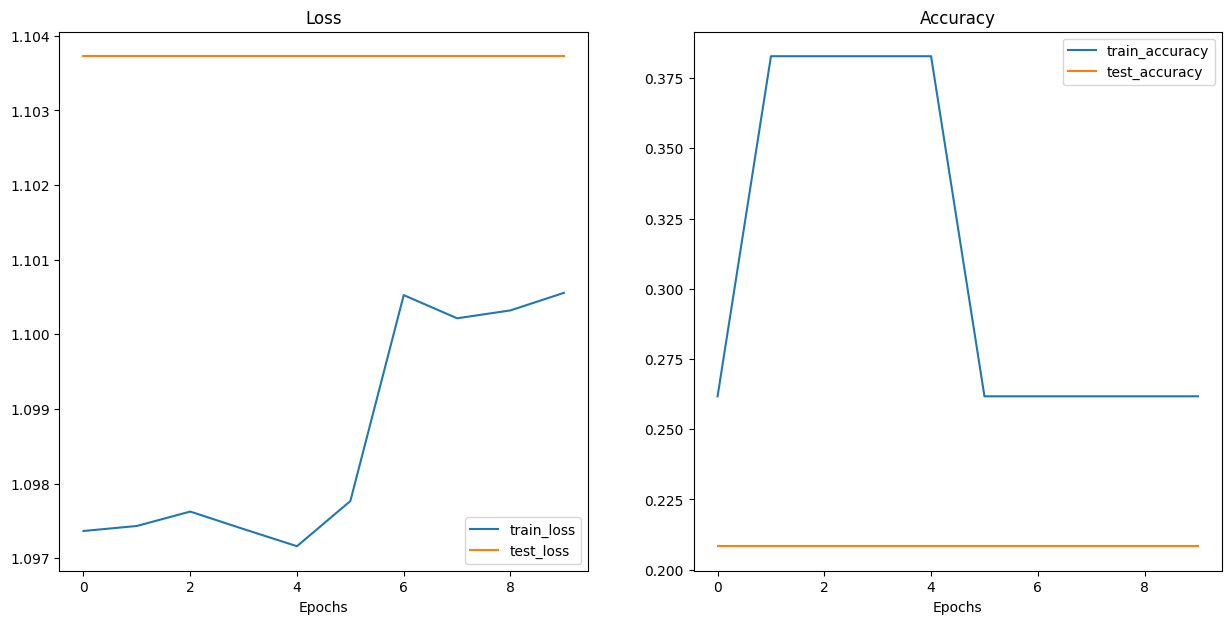

In [347]:
#Model_0 Loss Değerini Çizdirme
#model_0_results yazdıralım. -> model_0_results.keys()

def plot_loss_curves(results: Dict[str, List[float]]):
	#model_0_results'tan loss değerini alalım.
	loss = results["train_loss"]
	test_loss = results["test_loss"]

	#Tutarlılık değerlerini alalım.
	accuracy = results["train_acc"]
	test_accuracy = results["test_acc"]

	#kaç döngü de ne kadar loss var?
	epochs = range(len(results["train_loss"]))

	plt.figure(figsize=(15,7))
	plt.subplot(1,2,1)
	plt.plot(epochs, loss, label="train_loss")
	plt.plot(epochs, test_loss, label="test_loss")
	plt.title("Loss")
	plt.xlabel("Epochs")
	plt.legend()

	plt.subplot(1,2,2)
	plt.plot(epochs, accuracy, label="train_accuracy")
	plt.plot(epochs, test_accuracy, label="test_accuracy")
	plt.title("Accuracy")
	plt.xlabel("Epochs")
	plt.legend()

#Fonksiyonu çağıralım
plot_loss_curves(model_0_results)
